# **Water Supply and Energy Usage Analysis in African Regions**

**Leveraging data to classify regions, identify critical needs, and inform sustainable resource management for water and energy access.**

In [1]:
#Standard Libraries
import pandas as pd
import numpy as np
import joblib

#Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point

#Preprocessing and modeling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from branca.colormap import linear

import os
os.environ["OMP_NUM_THREADS"] = "3"

#For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

### **1. Setup & Data Preprocessing**

**a. Loading the dataset**

In [2]:
#DataFrame loading and preview
df = pd.read_csv(r"C:\Users\Moved Files\Desktop\Git Projects\Water Supply & Energy Usage (Africa)\Dataset Archive\_Water+Supply+and+Energy+Usage+Dataset+-+Africa_lga_key_data.csv")
df.head(3)

Unnamed: 0             lga  Borehole  Don't Know  Handpump  Overhead Tank  \
0         600  abia aba north         2           0         0              0   
1         707  abia aba south         1           2         0              0   
2         390  abia arochukwu         0           0         3             17   

   Rainwater Harvesting System  Tap  Unimproved  \
0                            0   37           0   
1                            0   12           0   
2                            0    3           0   

   Unimproved Large Diameter Well  ...  Untreated Surface Water  Unnamed: 14  \
0                               0  ...                        0          NaN   
1                               0  ...                        0          NaN   
2                               0  ...                        0          NaN   

   Average Nighttime mean  system:index     AREA  STATE  Latitude  Longitude  \
0                3.422659           698   18.116   Abia  5.100754   7.359617   
1                1.949728           699   51.131   Abia  5.071438   7.341737   
2                0.089510           656  386.125   Abia  5.498931   7.795863   

  PERIMETER   Population  
0    31.927  245825.2780  
1    29.855  380211.9108  
2   133.618  146354.5149  

[3 rows x 23 columns]

In [3]:
#Replacing spaces with underscores in column names
df.columns = df.columns.str.replace(' ', '_')

In [4]:
#DataFrame shape and columns
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (763, 23)
Columns: ['Unnamed:_0', 'lga', 'Borehole', "Don't_Know", 'Handpump', 'Overhead_Tank', 'Rainwater_Harvesting_System', 'Tap', 'Unimproved', 'Unimproved_Large_Diameter_Well', 'Unimproved_Rainwater_Harvesting_System', 'Unimproved_Well', 'Unprotected_Spring', 'Untreated_Surface_Water', 'Unnamed:_14', 'Average_Nighttime_mean', 'system:index', 'AREA', 'STATE', 'Latitude', 'Longitude', 'PERIMETER', 'Population']


**b. Dropping irrelevant columns**

In [5]:
#Dropping system index if there is
if "system:index" in df.columns:
    df.drop(columns=["system:index"], inplace=True)

In [6]:
#Dropping identifier ('Unnamed: 0') and empty (Unnamed: 14') columns
df.drop(['Unnamed:_0', 'Unnamed:_14'], axis = 1, inplace = True)
df.head(3)

lga  Borehole  Don't_Know  Handpump  Overhead_Tank  \
0  abia aba north         2           0         0              0   
1  abia aba south         1           2         0              0   
2  abia arochukwu         0           0         3             17   

   Rainwater_Harvesting_System  Tap  Unimproved  \
0                            0   37           0   
1                            0   12           0   
2                            0    3           0   

   Unimproved_Large_Diameter_Well  Unimproved_Rainwater_Harvesting_System  \
0                               0                                       0   
1                               0                                       0   
2                               0                                       0   

   Unimproved_Well  Unprotected_Spring  Untreated_Surface_Water  \
0                0                   0                        0   
1                0                   0                        0   
2                0                   0                        0   

   Average_Nighttime_mean     AREA STATE  Latitude  Longitude  PERIMETER  \
0                3.422659   18.116  Abia  5.100754   7.359617     31.927   
1                1.949728   51.131  Abia  5.071438   7.341737     29.855   
2                0.089510  386.125  Abia  5.498931   7.795863    133.618   

    Population  
0  245825.2780  
1  380211.9108  
2  146354.5149

In [7]:
#Nem DataFrame shape and columns
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (763, 20)
Columns: ['lga', 'Borehole', "Don't_Know", 'Handpump', 'Overhead_Tank', 'Rainwater_Harvesting_System', 'Tap', 'Unimproved', 'Unimproved_Large_Diameter_Well', 'Unimproved_Rainwater_Harvesting_System', 'Unimproved_Well', 'Unprotected_Spring', 'Untreated_Surface_Water', 'Average_Nighttime_mean', 'AREA', 'STATE', 'Latitude', 'Longitude', 'PERIMETER', 'Population']


In [8]:
#Converting the DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"
)

#Verifying the conversion
print(type(gdf))
print(gdf.crs)
print(gdf.shape)
gdf.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:4326
(763, 21)


lga  Borehole  Don't_Know  Handpump  Overhead_Tank  \
0  abia aba north         2           0         0              0   
1  abia aba south         1           2         0              0   
2  abia arochukwu         0           0         3             17   

   Rainwater_Harvesting_System  Tap  Unimproved  \
0                            0   37           0   
1                            0   12           0   
2                            0    3           0   

   Unimproved_Large_Diameter_Well  Unimproved_Rainwater_Harvesting_System  \
0                               0                                       0   
1                               0                                       0   
2                               0                                       0   

   ...  Unprotected_Spring  Untreated_Surface_Water  Average_Nighttime_mean  \
0  ...                   0                        0                3.422659   
1  ...                   0                        0                1.949728   
2  ...                   0                        0                0.089510   

      AREA  STATE  Latitude  Longitude  PERIMETER   Population  \
0   18.116   Abia  5.100754   7.359617     31.927  245825.2780   
1   51.131   Abia  5.071438   7.341737     29.855  380211.9108   
2  386.125   Abia  5.498931   7.795863    133.618  146354.5149   

                  geometry  
0  POINT (7.35962 5.10075)  
1  POINT (7.34174 5.07144)  
2  POINT (7.79586 5.49893)  

[3 rows x 21 columns]

In [9]:
#GeoDataFrame shape and columns
print("Shape:", gdf.shape)
print("Columns:", gdf.columns.tolist())

Shape: (763, 21)
Columns: ['lga', 'Borehole', "Don't_Know", 'Handpump', 'Overhead_Tank', 'Rainwater_Harvesting_System', 'Tap', 'Unimproved', 'Unimproved_Large_Diameter_Well', 'Unimproved_Rainwater_Harvesting_System', 'Unimproved_Well', 'Unprotected_Spring', 'Untreated_Surface_Water', 'Average_Nighttime_mean', 'AREA', 'STATE', 'Latitude', 'Longitude', 'PERIMETER', 'Population', 'geometry']


**c. Data description, types, and info**

In [10]:
#Data Description
gdf.describe().T.round(4)

count         mean          std  \
Borehole                                763.0      36.8585      60.3153   
Don't_Know                              763.0       5.3394      15.4341   
Handpump                                763.0      20.9253      54.7979   
Overhead_Tank                           763.0       5.5347      16.6087   
Rainwater_Harvesting_System             763.0       0.0249       0.3370   
Tap                                     763.0      58.8558      55.4025   
Unimproved                              763.0       8.1062      28.4732   
Unimproved_Large_Diameter_Well          763.0       1.6920       9.0596   
Unimproved_Rainwater_Harvesting_System  763.0       0.0315       0.4485   
Unimproved_Well                         763.0      35.1153      72.9966   
Unprotected_Spring                      763.0       0.5374       2.3543   
Untreated_Surface_Water                 763.0       0.6488       2.0967   
Average_Nighttime_mean                  763.0       0.7503       2.4850   
AREA                                    763.0    1152.8274    1402.6534   
Latitude                                763.0       8.6347       2.6447   
Longitude                               763.0       7.3074       2.4155   
PERIMETER                               763.0     150.3728      94.2765   
Population                              763.0  233411.0978  207140.5279   

                                              min          25%          50%  \
Borehole                                   0.0000       1.0000      12.0000   
Don't_Know                                 0.0000       0.0000       1.0000   
Handpump                                   0.0000       0.0000       0.0000   
Overhead_Tank                              0.0000       0.0000       0.0000   
Rainwater_Harvesting_System                0.0000       0.0000       0.0000   
Tap                                        0.0000      20.0000      44.0000   
Unimproved                                 0.0000       0.0000       0.0000   
Unimproved_Large_Diameter_Well             0.0000       0.0000       0.0000   
Unimproved_Rainwater_Harvesting_System     0.0000       0.0000       0.0000   
Unimproved_Well                            0.0000       0.0000       2.0000   
Unprotected_Spring                         0.0000       0.0000       0.0000   
Untreated_Surface_Water                    0.0000       0.0000       0.0000   
Average_Nighttime_mean                    -0.0317       0.0080       0.0456   
AREA                                      11.6450     284.0545     680.6200   
Latitude                                   4.4579       6.4628       7.9919   
Longitude                                  2.8002       5.5093       7.2826   
PERIMETER                                 13.0970      81.9085     129.3110   
Population                              3459.9782  114799.5446  190256.4587   

                                                75%           max  
Borehole                                    48.0000  4.980000e+02  
Don't_Know                                   4.0000  1.980000e+02  
Handpump                                     7.0000  5.970000e+02  
Overhead_Tank                                0.0000  1.590000e+02  
Rainwater_Harvesting_System                  0.0000  8.000000e+00  
Tap                                         82.0000  3.980000e+02  
Unimproved                                   2.0000  2.980000e+02  
Unimproved_Large_Diameter_Well               0.0000  1.120000e+02  
Unimproved_Rainwater_Harvesting_System       0.0000  1.100000e+01  
Unimproved_Well                             40.0000  8.920000e+02  
Unprotected_Spring                           0.0000  3.900000e+01  
Untreated_Surface_Water                      0.0000  2.700000e+01  
Average_Nighttime_mean                       0.2317  2.857230e+01  
AREA                                      1485.4245  1.035767e+04  
Latitude                                    11.3703  1.368670e+01  
Longitude               

In [11]:
#Data info
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   lga                                     763 non-null    object  
 1   Borehole                                763 non-null    int64   
 2   Don't_Know                              763 non-null    int64   
 3   Handpump                                763 non-null    int64   
 4   Overhead_Tank                           763 non-null    int64   
 5   Rainwater_Harvesting_System             763 non-null    int64   
 6   Tap                                     763 non-null    int64   
 7   Unimproved                              763 non-null    int64   
 8   Unimproved_Large_Diameter_Well          763 non-null    int64   
 9   Unimproved_Rainwater_Harvesting_System  763 non-null    int64   
 10  Unimproved_Well                         76

In [12]:
#Data types
gdf.dtypes

lga                                         object
Borehole                                     int64
Don't_Know                                   int64
Handpump                                     int64
Overhead_Tank                                int64
Rainwater_Harvesting_System                  int64
Tap                                          int64
Unimproved                                   int64
Unimproved_Large_Diameter_Well               int64
Unimproved_Rainwater_Harvesting_System       int64
Unimproved_Well                              int64
Unprotected_Spring                           int64
Untreated_Surface_Water                      int64
Average_Nighttime_mean                     float64
AREA                                       float64
STATE                                       object
Latitude                                   float64
Longitude                                  float64
PERIMETER                                  float64
Population                     

**d. Basic cleaning**

In [13]:
#Checking null values
gdf.isnull().sum()

lga                                       0
Borehole                                  0
Don't_Know                                0
Handpump                                  0
Overhead_Tank                             0
Rainwater_Harvesting_System               0
Tap                                       0
Unimproved                                0
Unimproved_Large_Diameter_Well            0
Unimproved_Rainwater_Harvesting_System    0
Unimproved_Well                           0
Unprotected_Spring                        0
Untreated_Surface_Water                   0
Average_Nighttime_mean                    0
AREA                                      0
STATE                                     0
Latitude                                  0
Longitude                                 0
PERIMETER                                 0
Population                                0
geometry                                  0
dtype: int64

In [14]:
#Checking duplicates
gdf.duplicated().sum()

0

In [15]:
#Modified DataFrame columns
gdf.columns

Index(['lga', 'Borehole', 'Don't_Know', 'Handpump', 'Overhead_Tank',
       'Rainwater_Harvesting_System', 'Tap', 'Unimproved',
       'Unimproved_Large_Diameter_Well',
       'Unimproved_Rainwater_Harvesting_System', 'Unimproved_Well',
       'Unprotected_Spring', 'Untreated_Surface_Water',
       'Average_Nighttime_mean', 'AREA', 'STATE', 'Latitude', 'Longitude',
       'PERIMETER', 'Population', 'geometry'],
      dtype='object')

**e. Handling outliers**

In [16]:
#New numerical features
num_features = gdf.select_dtypes(include=['int', 'float'])
print(num_features.columns)
n = len(list(num_features))
print('Numerical Features: ', n)

Index(['Borehole', 'Don't_Know', 'Handpump', 'Overhead_Tank',
       'Rainwater_Harvesting_System', 'Tap', 'Unimproved',
       'Unimproved_Large_Diameter_Well',
       'Unimproved_Rainwater_Harvesting_System', 'Unimproved_Well',
       'Unprotected_Spring', 'Untreated_Surface_Water',
       'Average_Nighttime_mean', 'AREA', 'Latitude', 'Longitude', 'PERIMETER',
       'Population'],
      dtype='object')
Numerical Features:  18


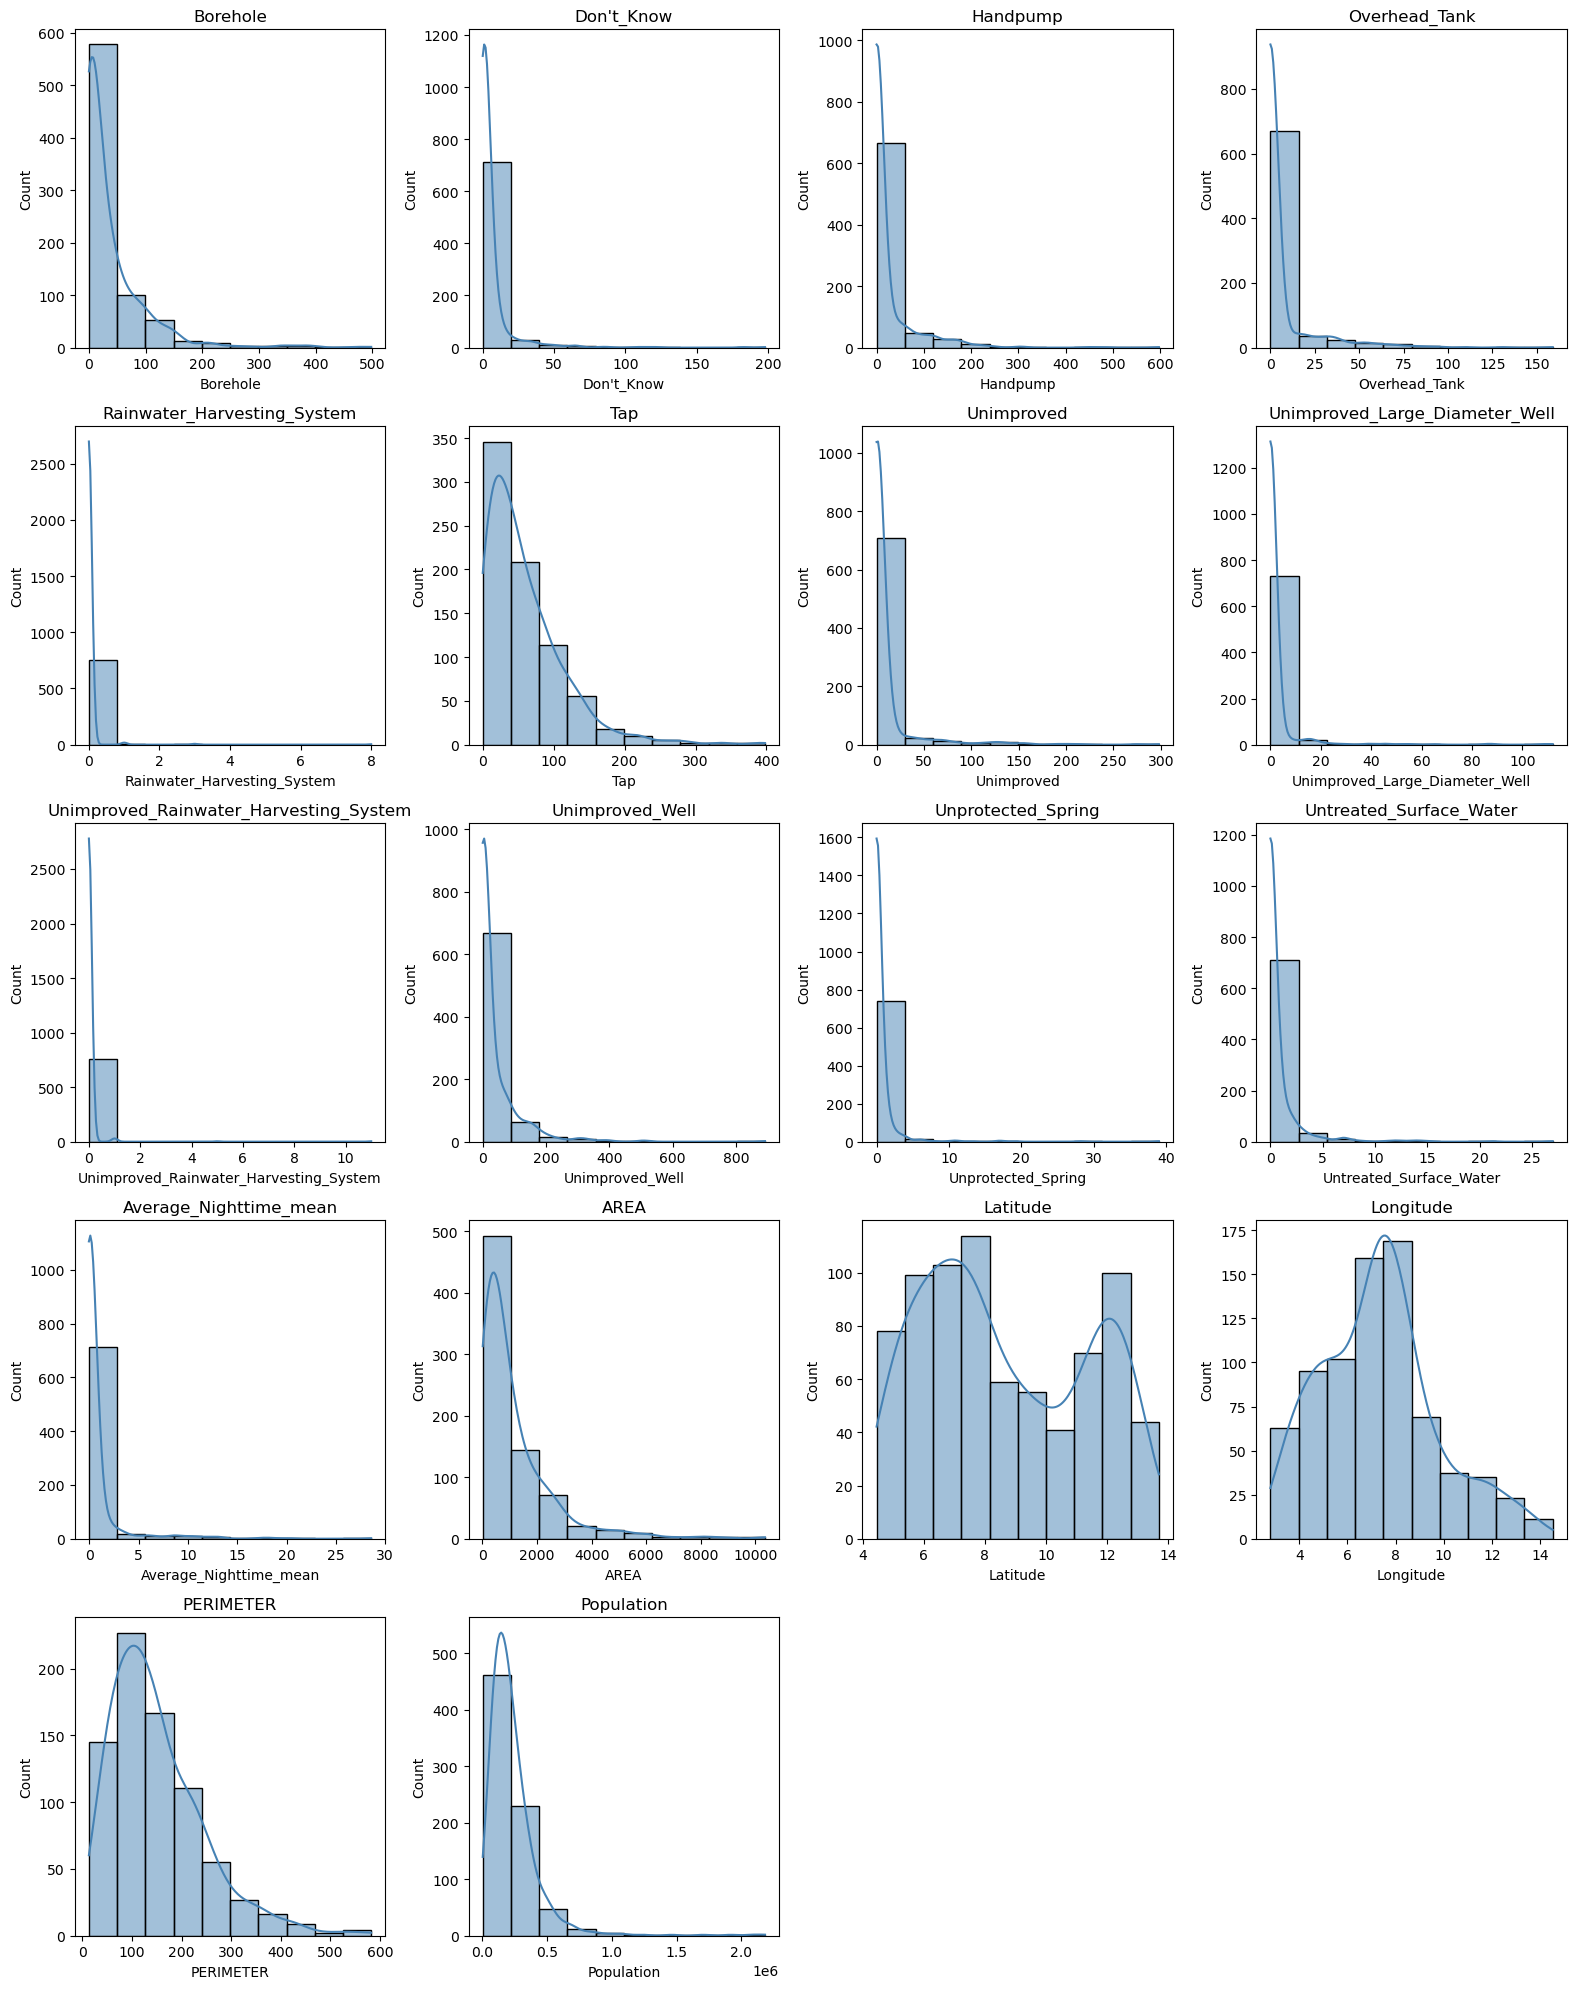

In [17]:
#Histograms (subplots) of variable distribution - outlier detection
#Calculating grid dimensions based on the number of features
n_features = 18  # Total number of numerical features
n_cols = 4       # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division = 5 rows

plt.figure(figsize = (16, 4 * n_rows))  # Adjust figure height based on number of rows

for i, col in enumerate(num_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, bins=10, color='steelblue')
    plt.title(col)

plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import mstats

#Outlier handling
def winsorize_data(data, num_features, limits=(0.1, 0.1)):
    """
    Cap outliers using Winsorization without removing rows.
    
    Parameters:
    - data: Input DataFrame
    - num_features: List of numerical columns
    - limits: Tuple of (lower percentile, upper percentile) to cap
    
    Returns:
    - DataFrame with capped values
    - Dictionary showing how many values were capped per feature
    """
    #Creating a copy to avoid modifying original data
    df_clean = data.copy()
    capped_report = {}
    
    
    for col in num_features:
        original = data[col].values
        winsorized = mstats.winsorize(original, limits=limits)
        df_clean[col] = winsorized
        
        #Counting how many values were changed
        n_capped = np.sum((original != winsorized) & ~np.isnan(original))
        capped_report[col] = n_capped
    
    print("\nValues capped per feature:")
    print(pd.Series(capped_report).sort_values(ascending=False))
    
    return df_clean 

In [19]:
#Applying outlier removal
winsorized_data = winsorize_data(df, num_features, limits=(0.1, 0.1))


Values capped per feature:
Population                                152
Average_Nighttime_mean                    152
PERIMETER                                 152
Longitude                                 152
Latitude                                  152
AREA                                      152
Tap                                       147
Handpump                                   76
Unimproved                                 76
Don't_Know                                 76
Unimproved_Well                            75
Overhead_Tank                              74
Borehole                                   74
Unimproved_Large_Diameter_Well             65
Unprotected_Spring                         57
Untreated_Surface_Water                    54
Unimproved_Rainwater_Harvesting_System     10
Rainwater_Harvesting_System                 8
dtype: int32


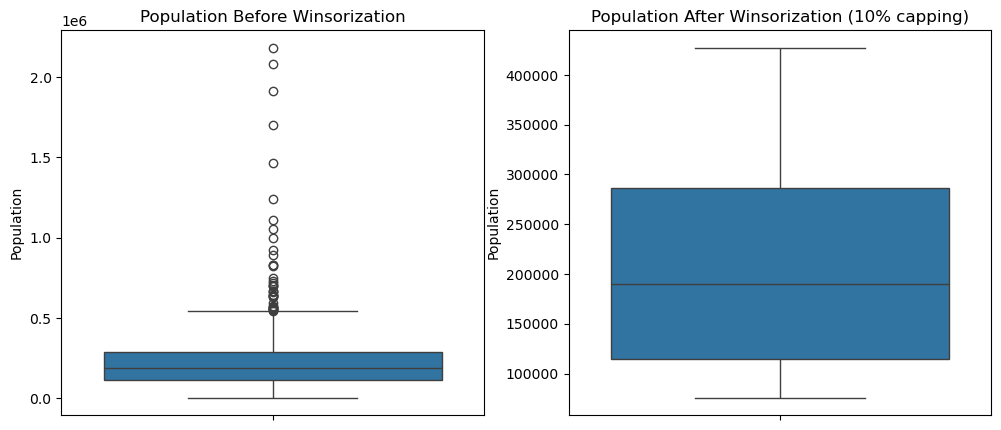

In [20]:
#Before-and-after comparison for a population
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='Population')
plt.title('Population Before Winsorization')

plt.subplot(1, 2, 2)
sns.boxplot(data=winsorized_data, y='Population')
plt.title('Population After Winsorization (10% capping)')
plt.show()

**f. Converting the DataFrame to GeoDataFrame**

**g. Feature Engineering**

In [21]:
#Count of unique lgas and states
print(len(gdf['lga'].unique()))
print(len(gdf['STATE'].unique()))

763
37


Since there are 763 samples and there are 763 unique LGAs, it means that each lga has a count of 1, thus no further engineering can be done, and will thus be encoded using frequency encoding.

In [22]:
#Top 20 STATES with counts
print("\nTop 20 STATES by count:")
gdf['STATE'].value_counts().head(20)


Top 20 STATES by count:


STATE
Kano         44
Katsina      34
Oyo          33
Akwa Ibom    31
Osun         30
Jigawa       27
Imo          27
Delta        25
Niger        25
Sokoto       23
Rivers       23
Benue        23
Kaduna       23
Borno        21
Adamawa      21
Anambra      21
Kebbi        21
Kogi         21
Lagos        20
Ogun         20
Name: count, dtype: int64

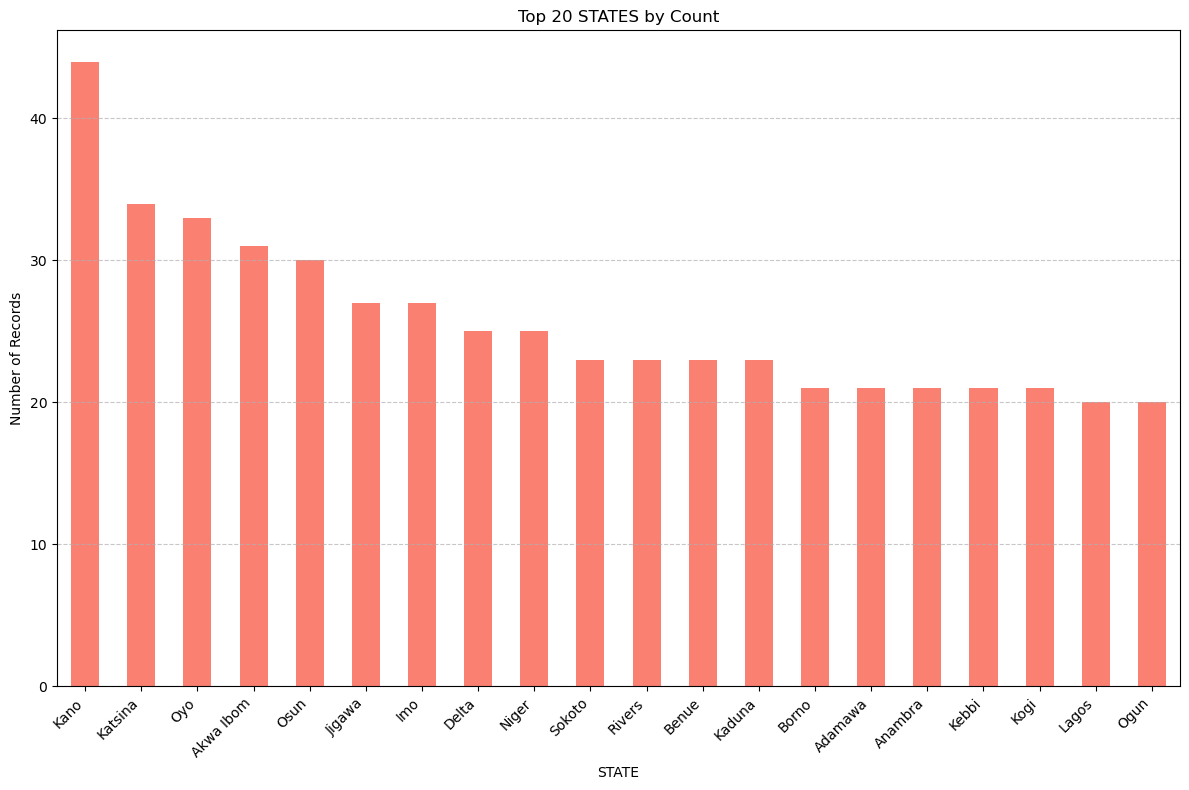

In [23]:
#Plotting top 20 STATES by count
plt.figure(figsize=(12,8))
gdf['STATE'].value_counts().head(20).plot(kind='bar', color='salmon')
plt.title('Top 20 STATES by Count')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
#Renaming states with counts less than 20 with others
#Getting value counts
state_counts = gdf['STATE'].value_counts()

#Identifying states with counts < 20
others_mask = gdf['STATE'].isin(state_counts[state_counts < 20].index)

#Creating a new column with 'Others' for low-frequency states
gdf['GROUPED_STATE'] = gdf['STATE'].where(~others_mask, 'Others')

#Verifying results
print("Modified STATE counts:")
gdf['GROUPED_STATE'].value_counts()

Modified STATE counts:


GROUPED_STATE
Others       250
Kano          44
Katsina       34
Oyo           33
Akwa Ibom     31
Osun          30
Imo           27
Jigawa        27
Delta         25
Niger         25
Kaduna        23
Benue         23
Rivers        23
Sokoto        23
Borno         21
Adamawa       21
Anambra       21
Kebbi         21
Kogi          21
Lagos         20
Ogun          20
Name: count, dtype: int64

In [25]:
gdf.drop('STATE', axis = 1, inplace = True)

In [26]:
#Creating distance to the centre in degrees (lat/long)
#Ensuring geometries exist
gdf = gdf.set_geometry("geometry")

#Computing the centroid of each GROUPED_STATE
state_centroids = gdf.dissolve(by="GROUPED_STATE").centroid

#Mapping states centroid back to each LGA
gdf["state_centroid"] = gdf["GROUPED_STATE"].map(state_centroids)

#ComputING distance from LGA centroid to its state centroid
gdf["Distance_to_Center"] = gdf.centroid.distance(gdf["state_centroid"])

In [27]:
#Population density
gdf["pop_density"] = gdf["Population"] / (gdf["AREA"].replace(0, np.nan))

#Safe vs unsafe water classification
safe_sources = ["Borehole", "Tap", "Overhead_Tank", "Rainwater_Harvesting_System"]
unsafe_sources = [
    "Unimproved", "Untreated_Surface_Water", "Unprotected_Spring",
    "Unimproved_Well", "Unimproved_Large_Diameter_Well", "Unimproved_Rainwater_Harvesting_System"
]

gdf["safe_water"] = gdf[safe_sources].sum(axis=1)
gdf["unsafe_water"] = gdf[unsafe_sources].sum(axis=1)

#Safe and unsafe ratios
gdf["safe_ratio"] = gdf["safe_water"] / gdf["Population"].replace(0, np.nan)
gdf["unsafe_ratio"] = gdf["unsafe_water"] / gdf["Population"].replace(0, np.nan)

#Water diversity - number of distinct sources > 0
gdf["water_diversity"] = (gdf[safe_sources + unsafe_sources] > 0).sum(axis=1)

#Climate stress - proxy: nighttime mean / population density
gdf["climate_stress"] = gdf["Average_Nighttime_mean"] / gdf["pop_density"].replace(0, np.nan)

#Accessibility - distance to center normalized by area
if "Distance_to_Center" in gdf.columns:
    gdf["accessibility"] = gdf["Distance_to_Center"] / gdf["AREA"].replace(0, np.nan)

#Compactness - (perimeter^2 / area)
gdf["compactness"] = (gdf["PERIMETER"] ** 2) / gdf["AREA"].replace(0, np.nan)

In [28]:
gdf.head(3)

lga  Borehole  Don't_Know  Handpump  Overhead_Tank  \
0  abia aba north         2           0         0              0   
1  abia aba south         1           2         0              0   
2  abia arochukwu         0           0         3             17   

   Rainwater_Harvesting_System  Tap  Unimproved  \
0                            0   37           0   
1                            0   12           0   
2                            0    3           0   

   Unimproved_Large_Diameter_Well  Unimproved_Rainwater_Harvesting_System  \
0                               0                                       0   
1                               0                                       0   
2                               0                                       0   

   ...  Distance_to_Center   pop_density  safe_water  unsafe_water  \
0  ...            3.180687  13569.511923          39             0   
1  ...            3.212486   7436.035102          13             0   
2  ...            2.743393    379.034030          20             0   

   safe_ratio  unsafe_ratio  water_diversity  climate_stress  accessibility  \
0    0.000159           0.0                2        0.000252       0.175573   
1    0.000034           0.0                2        0.000262       0.062829   
2    0.000137           0.0                2        0.000236       0.007105   

  compactness  
0   56.267020  
1   17.432106  
2   46.238316  

[3 rows x 32 columns]

**h. Quick sanity check**

In [29]:
print("\nNew engineered features:")
print([c for c in gdf.columns if c not in df.columns])

print("\nSample rows:")
gdf.head(3)


New engineered features:
['geometry', 'GROUPED_STATE', 'state_centroid', 'Distance_to_Center', 'pop_density', 'safe_water', 'unsafe_water', 'safe_ratio', 'unsafe_ratio', 'water_diversity', 'climate_stress', 'accessibility', 'compactness']

Sample rows:


lga  Borehole  Don't_Know  Handpump  Overhead_Tank  \
0  abia aba north         2           0         0              0   
1  abia aba south         1           2         0              0   
2  abia arochukwu         0           0         3             17   

   Rainwater_Harvesting_System  Tap  Unimproved  \
0                            0   37           0   
1                            0   12           0   
2                            0    3           0   

   Unimproved_Large_Diameter_Well  Unimproved_Rainwater_Harvesting_System  \
0                               0                                       0   
1                               0                                       0   
2                               0                                       0   

   ...  Distance_to_Center   pop_density  safe_water  unsafe_water  \
0  ...            3.180687  13569.511923          39             0   
1  ...            3.212486   7436.035102          13             0   
2  ...            2.743393    379.034030          20             0   

   safe_ratio  unsafe_ratio  water_diversity  climate_stress  accessibility  \
0    0.000159           0.0                2        0.000252       0.175573   
1    0.000034           0.0                2        0.000262       0.062829   
2    0.000137           0.0                2        0.000236       0.007105   

  compactness  
0   56.267020  
1   17.432106  
2   46.238316  

[3 rows x 32 columns]

**i. Exploratory distributions**

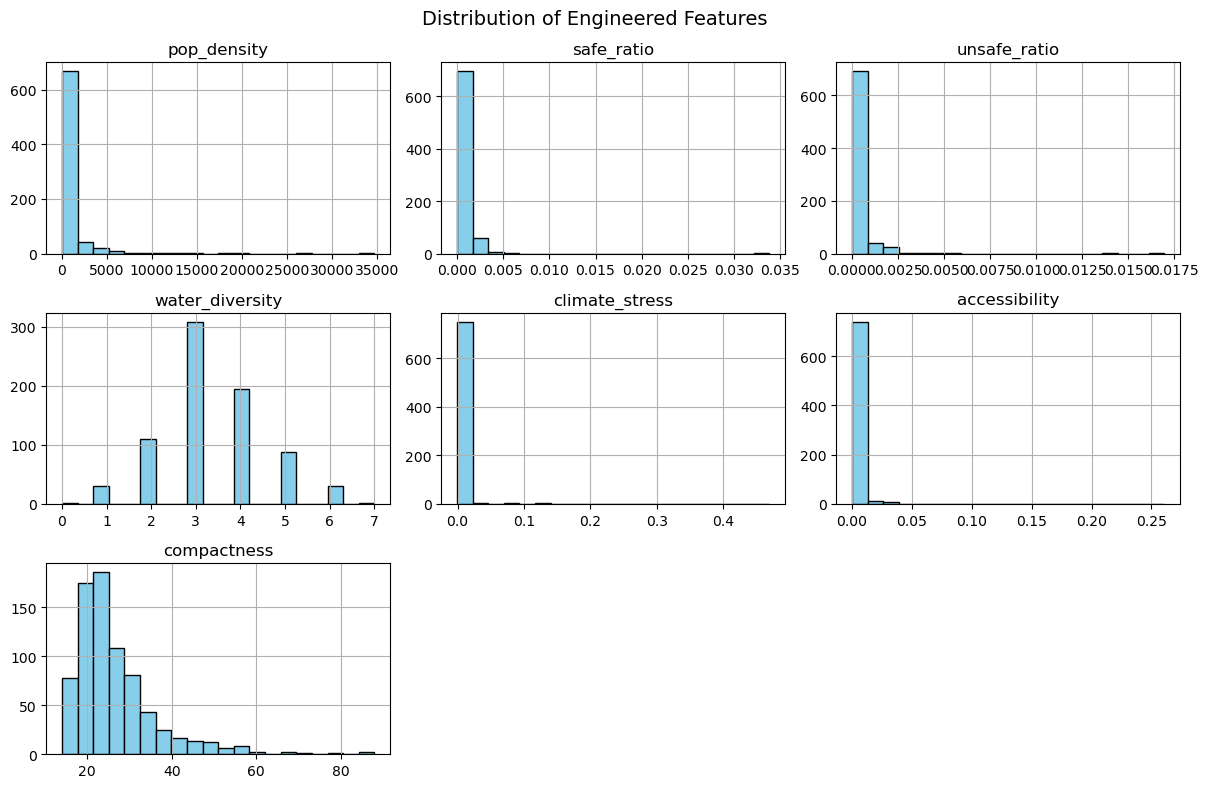

In [30]:
num_cols = ["pop_density", "safe_ratio", "unsafe_ratio",
            "water_diversity", "climate_stress", "accessibility", "compactness"]

gdf[num_cols].hist(bins=20, figsize=(12,8), color="skyblue", edgecolor="black")
plt.suptitle("Distribution of Engineered Features", fontsize=14)
plt.tight_layout()
plt.show()

### **2. Regional Classification for Solar Panel Optimization**

**a. Defining/Checking Solar Tier Label**

In [31]:
#Combining climate and population density as drivers of solar performance
gdf["Solar_Tier"] = (
    (gdf["Average_Nighttime_mean"].rank(pct=True)) * 0.6 +
    (gdf["pop_density"].rank(pct=True)) * 0.4
)

#Binning into Low, Medium, and High
if "Solar_Tier_Label" not in gdf.columns:
    if "Solar_Tier" in gdf.columns:
        bins = [0, 0.33, 0.66, 1.0]
        labels = ["Low", "Medium", "High"]
        gdf["Solar_Tier_Label"] = pd.cut(gdf["Solar_Tier"], bins=bins, labels=labels)
    else:
        print("⚠️ 'Solar_Tier' not in dataset — skipping label creation")

print("Solar Tier Distribution:")
print(gdf["Solar_Tier_Label"].value_counts(dropna=False))

Solar Tier Distribution:
Solar_Tier_Label
Medium    277
Low       246
High      240
Name: count, dtype: int64


**b. Feature selection and Encoding**

In [32]:
#Defining important numeric features
feature_cols = [
    "pop_density", "safe_ratio", "unsafe_ratio", "water_diversity",
    "climate_stress", "compactness", "Distance_to_Center",
    "Average_Nighttime_mean", "AREA", "Population"
]

ohe_col = ["GROUPED_STATE"]

freq_col = ["lga"]

#Starting with numeric subset + categorical to encode
X = gdf[feature_cols + ohe_col + freq_col].copy()

#One-hot encoding states and dropping "Others"
dummies = pd.get_dummies(X["GROUPED_STATE"], prefix="state", drop_first=True).astype(int)

#Frequency encoding LGAs
lga_freq = X["lga"].value_counts(normalize=True)
X["lga_encoded"] = X["lga"].map(lga_freq)

#Final feature matrix (drop raw categorical cols)
X = pd.concat([X.drop(columns=["GROUPED_STATE", "lga"]), dummies], axis=1)

#Defining the target
y = gdf["Solar_Tier_Label"]

In [33]:
#Features preview
X.head(3)

pop_density  safe_ratio  unsafe_ratio  water_diversity  climate_stress  \
0  13569.511923    0.000159           0.0                2        0.000252   
1   7436.035102    0.000034           0.0                2        0.000262   
2    379.034030    0.000137           0.0                2        0.000236   

   compactness  Distance_to_Center  Average_Nighttime_mean     AREA  \
0    56.267020            3.180687                3.422659   18.116   
1    17.432106            3.212486                1.949728   51.131   
2    46.238316            2.743393                0.089510  386.125   

    Population  ...  state_Kebbi  state_Kogi  state_Lagos  state_Niger  \
0  245825.2780  ...            0           0            0            0   
1  380211.9108  ...            0           0            0            0   
2  146354.5149  ...            0           0            0            0   

   state_Ogun  state_Osun  state_Others  state_Oyo  state_Rivers  state_Sokoto  
0           0           0             1          0             0             0  
1           0           0             1          0             0             0  
2           0           0             1          0             0             0  

[3 rows x 31 columns]

In [34]:
#Target preview
y.head(3)

0      High
1      High
2    Medium
Name: Solar_Tier_Label, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

**c. Supervised Model - Random Forest**

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred))


Classification Report (Random Forest):
              precision    recall  f1-score   support

        High       1.00      0.90      0.95        48
         Low       0.92      0.98      0.95        49
      Medium       0.90      0.93      0.91        56

    accuracy                           0.93       153
   macro avg       0.94      0.93      0.94       153
weighted avg       0.94      0.93      0.93       153



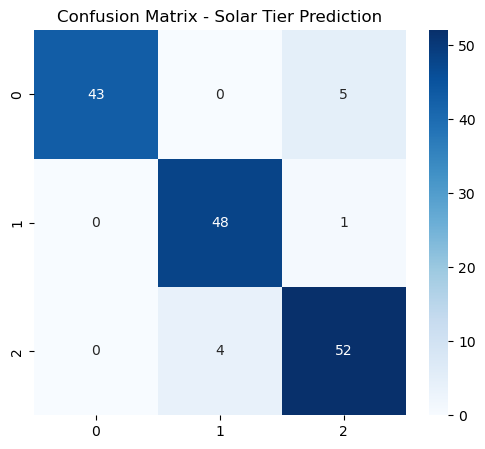

In [36]:
# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Solar Tier Prediction")
plt.show()

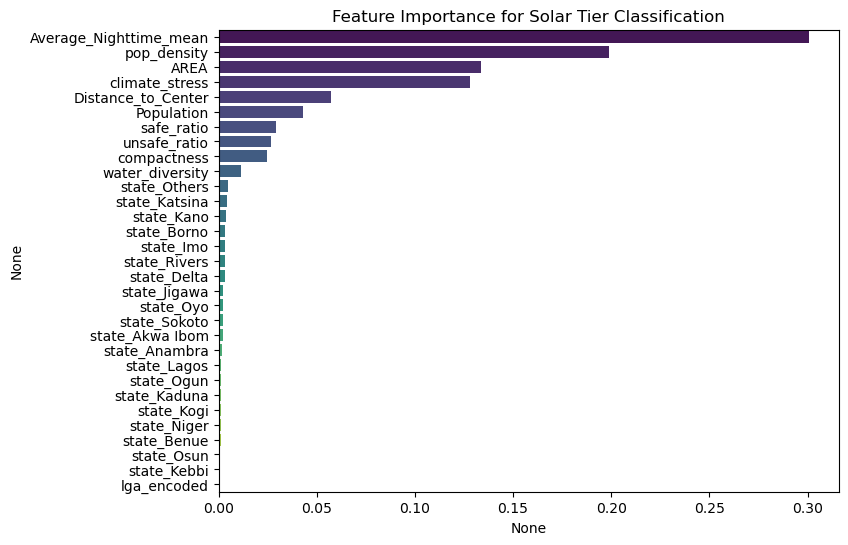

In [37]:
# Feature Importance
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Feature Importance for Solar Tier Classification")
plt.show()

**d. Unsupervised Model - KMeans**

In [38]:
feature_cols = [
        "pop_density", "safe_ratio", "unsafe_ratio", "water_diversity",
        "climate_stress", "compactness", "Distance_to_Center",
        "Average_Nighttime_mean", "AREA", "Population"
    ]

In [39]:
#Scaling data (only numeric features) for clustering
scaler = StandardScaler()
X_scaled = X.copy() 
X_scaled[feature_cols] = scaler.fit_transform(X[feature_cols])
X_scaled_df = pd.DataFrame(X_scaled)

In [40]:
X_scaled_df.head(3)

pop_density  safe_ratio  unsafe_ratio  water_diversity  climate_stress  \
0     4.132458   -0.392226     -0.355223        -1.228193       -0.106673   
1     2.104461   -0.479992     -0.355223        -1.228193       -0.106246   
2    -0.228893   -0.407737     -0.355223        -1.228193       -0.107362   

   compactness  Distance_to_Center  Average_Nighttime_mean      AREA  \
0     3.113622            1.424092                1.076099 -0.809506   
1    -0.950493            1.448089                0.482973 -0.785953   
2     2.064108            1.094088               -0.266108 -0.546967   

   Population  ...  state_Kebbi  state_Kogi  state_Lagos  state_Niger  \
0    0.059971  ...            0           0            0            0   
1    0.709166  ...            0           0            0            0   
2   -0.420554  ...            0           0            0            0   

   state_Ogun  state_Osun  state_Others  state_Oyo  state_Rivers  state_Sokoto  
0           0           0             1          0             0             0  
1           0           0             1          0             0             0  
2           0           0             1          0             0             0  

[3 rows x 31 columns]

In [41]:
#Determining optimal k using silhouette & inertia
inertia = []
sil_scores = []
models = {}

K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    labels = kmeans.labels_

    sil = silhouette_score(X_scaled_df, labels)
    inertia_val = kmeans.inertia_

    inertia.append(inertia_val)
    sil_scores.append(sil)
    models[k] = (kmeans, labels)

    print(f"\033[1mFitting KMeans for k = {k}\033[0m: Silhouette = {sil:.3f} while Inertia = {inertia_val:.2f}")  

Fitting KMeans for k = 2: Silhouette = 0.522 while Inertia = 7273.78
Fitting KMeans for k = 3: Silhouette = 0.526 while Inertia = 6514.60
Fitting KMeans for k = 4: Silhouette = 0.182 while Inertia = 5753.48
Fitting KMeans for k = 5: Silhouette = 0.124 while Inertia = 5354.41
Fitting KMeans for k = 6: Silhouette = 0.136 while Inertia = 4798.05
Fitting KMeans for k = 7: Silhouette = 0.153 while Inertia = 4421.20
Fitting KMeans for k = 8: Silhouette = 0.166 while Inertia = 4092.56
Fitting KMeans for k = 9: Silhouette = 0.168 while Inertia = 3776.62
Fitting KMeans for k = 10: Silhouette = 0.170 while Inertia = 3485.99


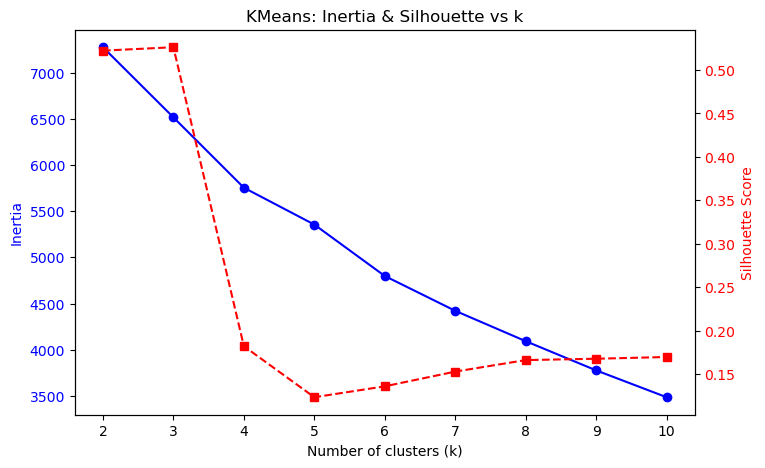

In [42]:
#Plotting inertia vs silhouette
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(K, inertia, 'o-', color="blue", label="Inertia (SSE)")
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Inertia", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(K, sil_scores, 's--', color="red", label="Silhouette")
ax2.set_ylabel("Silhouette Score", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("KMeans: Inertia & Silhouette vs k")
plt.show()

In [43]:
#Picking the best k, at k = 3
best_k = 3
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
best_labels = kmeans_final.fit_predict(X_scaled)

In [44]:
#KMeans model Evaluation
print("KMeans Inertia (WCSS):", kmeans_final.inertia_)

sil_score = silhouette_score(X_scaled[feature_cols], best_labels)
print("Silhouette Score:", sil_score)

db_score = davies_bouldin_score(X_scaled[feature_cols], best_labels)
print("Davies-Bouldin Index:", db_score)

KMeans Inertia (WCSS): 6514.599599875811
Silhouette Score: 0.5556750398367801
Davies-Bouldin Index: 1.0701780454265355
Cluster sizes:
 0    718
1      1
2     44
Name: count, dtype: int64


In [45]:
#Assigning clusters back
gdf["Cluster"] = best_labels

print("\nFinal Cluster Distribution:")
gdf["Cluster"].value_counts()


Final Cluster Distribution:


Cluster
0    718
2     44
1      1
Name: count, dtype: int64

In [46]:
import pandas as pd

#Cluster centers from KMeans
cluster_centers = pd.DataFrame(kmeans_final.cluster_centers_, columns=X_scaled.columns)

#Creating a copy to avoid modifying encoded columns
cluster_centers_interpretable = cluster_centers.copy()

#Inverse-transformig only numeric features
cluster_centers_interpretable.loc[:, feature_cols] = scaler.inverse_transform(
    cluster_centers_interpretable[feature_cols]
)

print("\nCluster Centers (numeric features back to original scale, encoded unchanged):")
cluster_centers_interpretable


Cluster Centers (numeric features back to original scale, encoded unchanged):


pop_density  safe_ratio  unsafe_ratio  water_diversity  climate_stress  \
0   596.726157    0.000672      0.000332         3.402507        0.000821   
1    20.643645    0.033815      0.014162         4.000000        0.013163   
2  8839.342801    0.000658      0.000139         3.090909        0.033850   

   compactness  Distance_to_Center  Average_Nighttime_mean         AREA  \
0    26.485050            1.344095                0.266935  1206.558702   
1    23.228042            0.550764                0.271732   167.605000   
2    27.071577            0.486478                8.649605   298.421955   

      Population  ...   state_Kebbi    state_Kogi  state_Lagos  state_Niger  \
0  216444.472165  ...  2.924791e-02  2.924791e-02     0.008357     0.034819   
1    3459.978200  ...  0.000000e+00  0.000000e+00     0.000000     0.000000   
2  515501.742209  ... -6.938894e-18 -6.938894e-18     0.318182     0.000000   

   state_Ogun    state_Osun  state_Others  state_Oyo  state_Rivers  \
0    0.025070  4.178273e-02      0.342618   0.043175      0.022284   
1    0.000000  0.000000e+00      0.000000   0.000000      1.000000   
2    0.045455 -1.387779e-17      0.090909   0.045455      0.136364   

   state_Sokoto  
0      0.030641  
1      0.000000  
2      0.022727  

[3 rows x 31 columns]

**e. Visualizations**

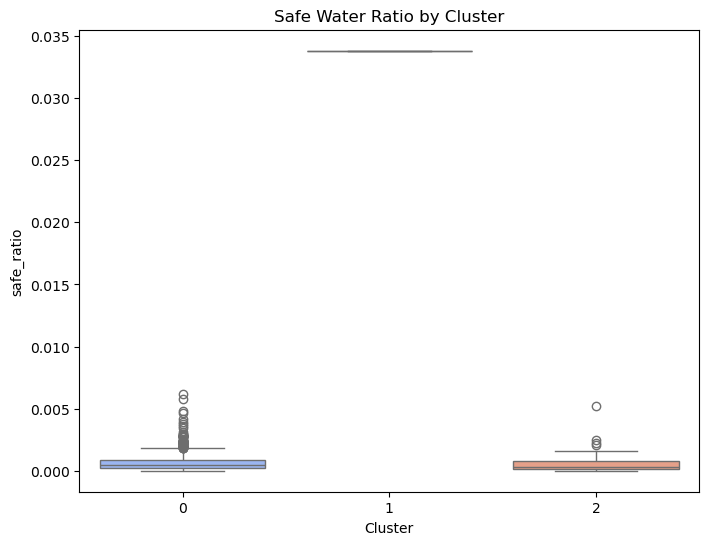

In [47]:
#Boxplot: Cluster vs Safe Water Ratio
plt.figure(figsize=(8,6))
sns.boxplot(data=gdf, x="Cluster", y="safe_ratio", palette="coolwarm")
plt.title("Safe Water Ratio by Cluster")
plt.show()

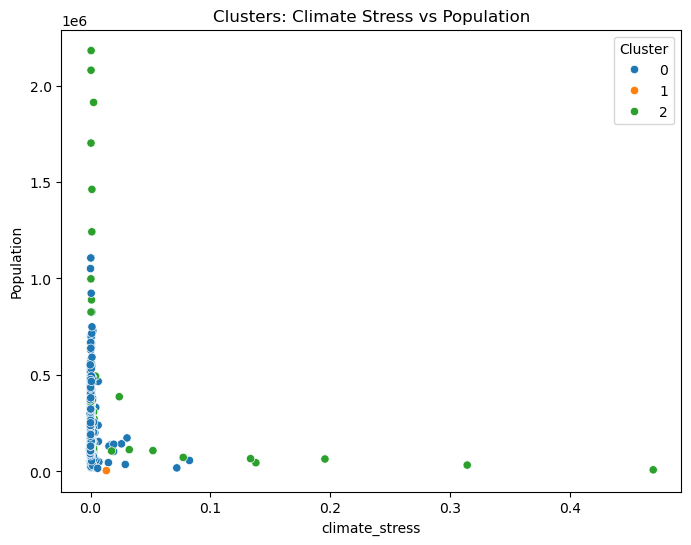

In [48]:
#Scatter: Climate Stress vs Population, colored by Cluster
plt.figure(figsize=(8,6))
sns.scatterplot(data=gdf, x="climate_stress", y="Population", hue="Cluster", palette="tab10")
plt.title("Clusters: Climate Stress vs Population")
plt.show()

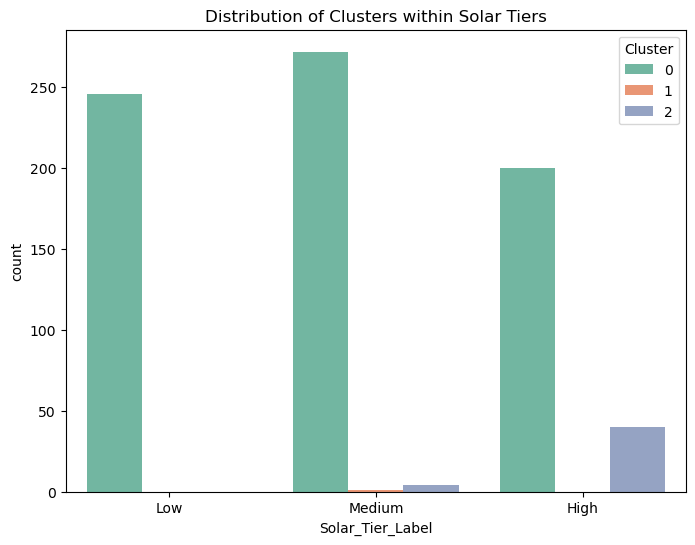

In [49]:
#Compare supervised vs unsupervised
plt.figure(figsize=(8,6))
sns.countplot(data=gdf, x="Solar_Tier_Label", hue="Cluster", palette="Set2")
plt.title("Distribution of Clusters within Solar Tiers")
plt.show()

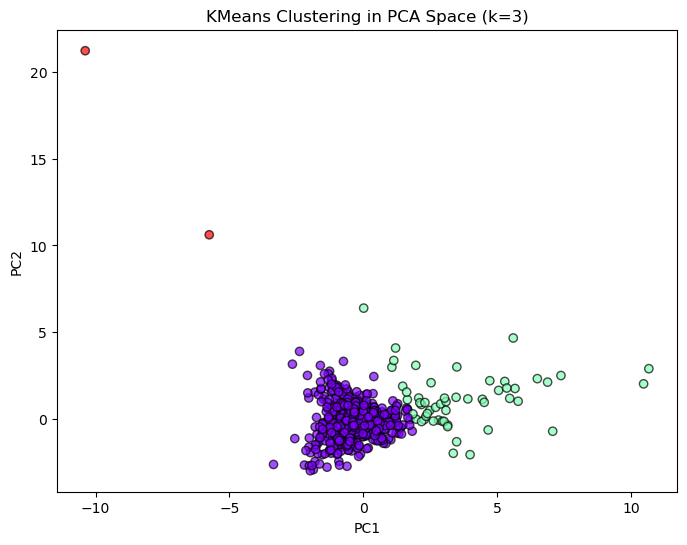

In [50]:
#2D PCA Visualization of Clusters
#Applying PCA to reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

#Running KMeans with best_k (already determined earlier)
kmeans_pca = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_pca.fit_predict(X_pca)

#Visualizing clusters in PCA space
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="rainbow", alpha=0.7, edgecolors="k")
plt.title(f"KMeans Clustering in PCA Space (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

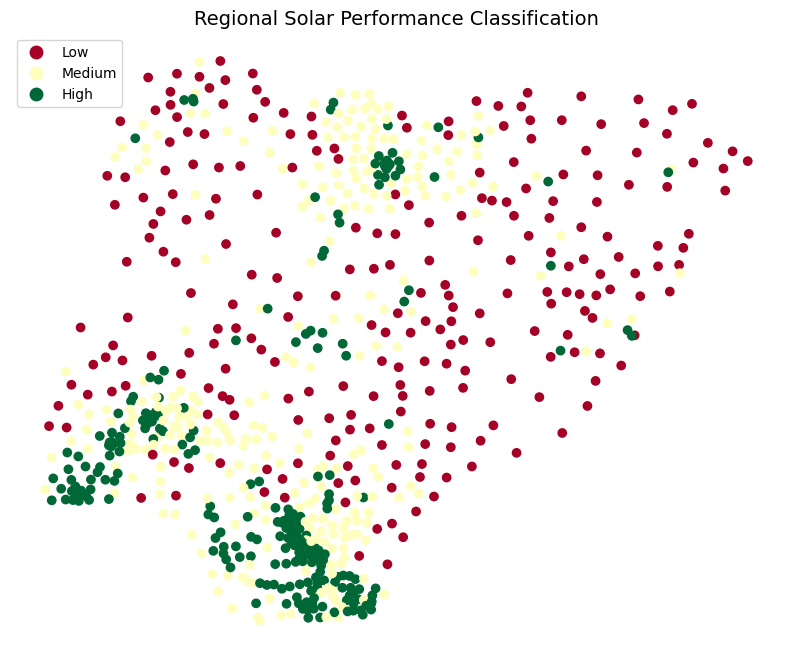

In [51]:
#Map of Solar Tiers
fig, ax = plt.subplots(1, 1, figsize=(10,8))
gdf.plot(
    column="Solar_Tier_Label",
    cmap="RdYlGn",
    legend=True,
    ax=ax,
    categorical=True
)
ax.set_title("Regional Solar Performance Classification", fontsize=14)
plt.axis("off")
plt.show()

In [52]:
#Defining consistent colors for tiers
tier_colors = {
    "Low": "red",
    "Medium": "orange",
    "High": "green"
}

#Base map centered on dataset
m = folium.Map(
    location=[gdf['Latitude'].mean(), gdf['Longitude'].mean()],
    zoom_start=6,
    tiles='CartoDB positron'
)

#Adding markers for all regions
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=tier_colors.get(row['Solar_Tier_Label'], "gray"),  # fallback color
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"""
            <b>LGA:</b> {row['lga']}<br>
            <b>State:</b> {row['GROUPED_STATE']}<br>
            <b>Solar Tier:</b> {row['Solar_Tier_Label']}<br>
            <b>Avg Nighttime Mean:</b> {row['Average_Nighttime_mean']:.1f}
            """,
            max_width=250
        ),
        tooltip=row['Solar_Tier_Label']
    ).add_to(m)

#Adding legend (continuous scale, optional)
colormap = linear.YlOrRd_03.scale(
    gdf['Average_Nighttime_mean'].min(),
    gdf['Average_Nighttime_mean'].max()
)
colormap.caption = 'Average_Nighttime_Mean'
colormap.add_to(m)

#Saving & displaying
m.save("solar_classification_map.html")
m

### **3. Identification of Energy & Water Supply Needs**

In [53]:
#Creating the GeoDataFrame copy to work on
gdf_needs = gdf.copy()

**a. Engineer Energy & Water Need Indicators**

In [54]:
#Water stress proxy - unsafe water sources relative to density
gdf_needs["water_need_index"] = (gdf_needs["unsafe_water"] / (gdf_needs["pop_density"] + 1))

#Energy demand proxy - climate stress × population
gdf_needs["energy_need_index"] = gdf_needs["climate_stress"] * gdf_needs["Population"]

#Accessibility gap - distance × population
gdf_needs["infra_gap_index"] = gdf_needs["Distance_to_Center"] * gdf_needs["Population"]

#Combined index (weights can be tuned)
gdf_needs["combined_need_index"] = (
    0.4 * gdf_needs["water_need_index"] +
    0.4 * gdf_needs["energy_need_index"].rank(pct=True) + 
    0.2 * gdf_needs["infra_gap_index"].rank(pct=True)
)

**b. Visualize Distributions**

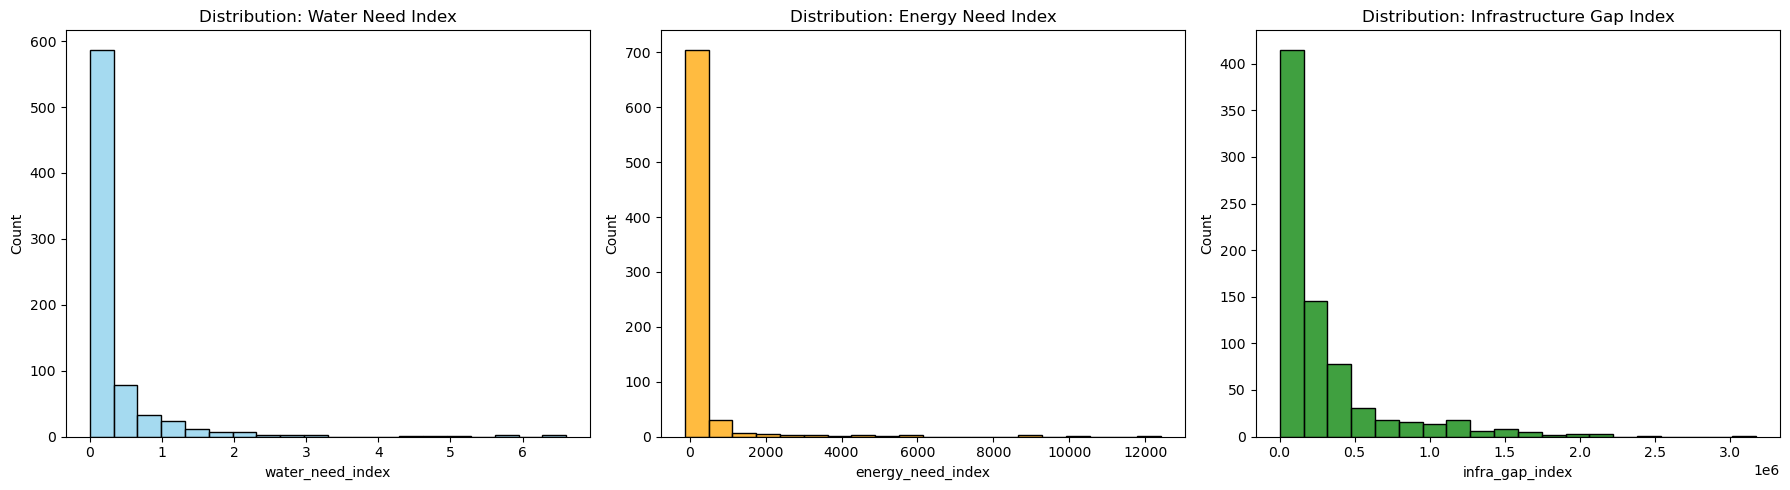

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(gdf_needs["water_need_index"], bins=20, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution: Water Need Index")

sns.histplot(gdf_needs["energy_need_index"], bins=20, ax=axes[1], color="orange")
axes[1].set_title("Distribution: Energy Need Index")

sns.histplot(gdf_needs["infra_gap_index"], bins=20, ax=axes[2], color="green")
axes[2].set_title("Distribution: Infrastructure Gap Index")

plt.tight_layout()
plt.show()

**c. Heatmap (Static GeoPandas Plot)**

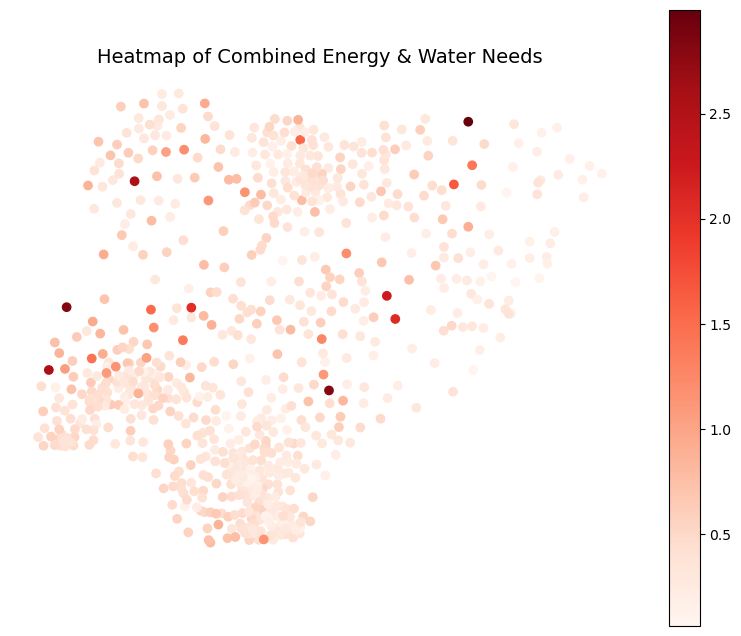

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
gdf_needs.plot(
    column="combined_need_index",
    cmap="Reds",
    legend=True,
    ax=ax
)
ax.set_title("Heatmap of Combined Energy & Water Needs", fontsize=14)
plt.axis("off")
plt.show()

**d. Interactive Folium Map**

In [57]:
m2 = folium.Map(
    location=[gdf_needs['Latitude'].mean(), gdf_needs['Longitude'].mean()],
    zoom_start=6,
    tiles="CartoDB positron"
)

# Normalize for colormap
colormap = linear.Reds_09.scale(
    gdf_needs["combined_need_index"].min(),
    gdf_needs["combined_need_index"].max()
)
colormap.caption = "Combined Need Index"
colormap.add_to(m2)

# Add markers
for _, row in gdf_needs.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        color=colormap(row["combined_need_index"]),
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"""
            <b>LGA:</b> {row['lga']}<br>
            <b>State:</b> {row['GROUPED_STATE']}<br>
            <b>Water Need Index:</b> {row['water_need_index']:.2f}<br>
            <b>Energy Need Index:</b> {row['energy_need_index']:.2f}<br>
            <b>Infra Gap Index:</b> {row['infra_gap_index']:.2f}<br>
            <b>Combined Index:</b> {row['combined_need_index']:.2f}
            """,
            max_width=280
        ),
        tooltip=f"Need Index: {row['combined_need_index']:.2f}"
    ).add_to(m2)

# Save and display
m2.save("energy_water_needs_map.html")
m2

**e. Ranking Critical Regions**

In [58]:
#Top 10 LGAs with Highest Combined Need Index
top10_lgas = (
    gdf_needs[["lga", "GROUPED_STATE", "water_need_index", "energy_need_index",
               "infra_gap_index", "combined_need_index"]]
    .sort_values("combined_need_index", ascending=False)
    .head(10)
)

print("Top 10 Most Critical LGAs (by Combined Need Index):")
top10_lgas

Top 10 Most Critical LGAs (by Combined Need Index):


lga GROUPED_STATE  water_need_index  energy_need_index  \
747  yobe yunusari        Others          6.604658          16.887379   
481  kwara baruten        Others          5.885964          66.359445   
136    benue tarka         Benue          6.480630          31.482869   
639    oyo iwajowa           Oyo          5.731643          33.992171   
704   sokoto kebbe        Sokoto          5.940722           3.329353   
661  plateau kanam        Others          5.167886         -53.430726   
671   plateau wase        Others          4.732619         -77.479522   
536    niger gbako         Niger          4.597981          14.259014   
736      yobe fune        Others          3.209759          23.742852   
321   jigawa gwiwa        Jigawa          2.904092          63.796061   

     infra_gap_index  combined_need_index  
747     1.295924e+06             2.993632  
481     1.229271e+06             2.829353  
136     2.099834e+04             2.819775  
639     6.171732e+04             2.564479  
704     1.017431e+05             2.540640  
661     3.752948e+05             2.229933  
671     5.392370e+05             2.067360  
536     6.181371e+04             2.041027  
736     1.416951e+06             1.665817  
321     1.273276e+05             1.536735

In [59]:
#Aggregate at State Level (mean combined need index)
state_ranking = (
    gdf_needs.groupby("GROUPED_STATE")["combined_need_index"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

print("\nState-Level Ranking (Mean Combined Need Index):")
state_ranking.head(10)


State-Level Ranking (Mean Combined Need Index):


GROUPED_STATE  combined_need_index
0           Oyo             0.651008
1         Niger             0.619418
2         Benue             0.535297
3        Sokoto             0.530053
4        Rivers             0.509669
5        Others             0.479471
6        Jigawa             0.428647
7         Lagos             0.423922
8         Delta             0.414695
9          Ogun             0.413788

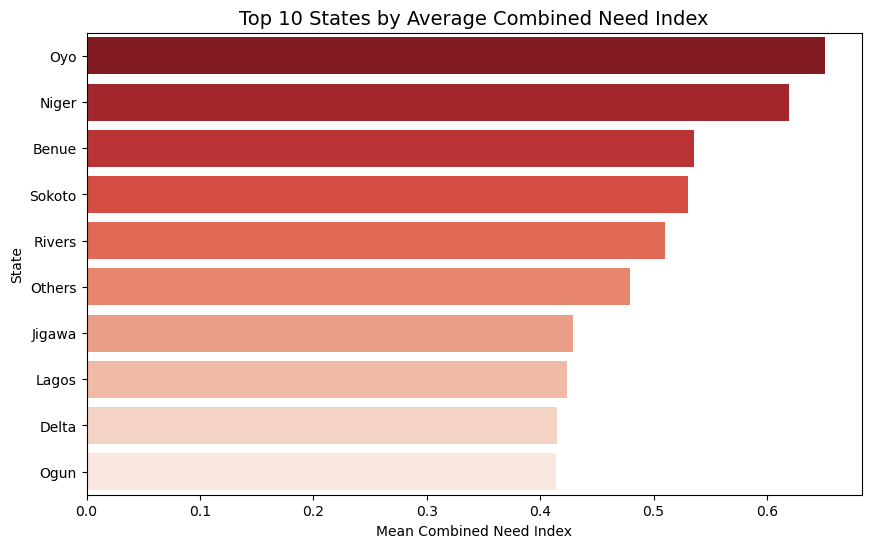

In [60]:
#Visualization of Top States
plt.figure(figsize=(10,6))
sns.barplot(
    data=state_ranking.head(10),
    x="combined_need_index",
    y="GROUPED_STATE",
    palette="Reds_r"
)
plt.title("Top 10 States by Average Combined Need Index", fontsize=14)
plt.xlabel("Mean Combined Need Index")
plt.ylabel("State")
plt.show()

### **4. Resource Allocation & Policy Recommendations**

**a. Defining Priority Index**

In [61]:
#Combining needs - unsafe water, population pressure, climate stress, and solar tier
#Weights can be adjusted based on domain knowledge or stakeholder feedback
gdf["Priority_Index"] = (
    0.4 * gdf["unsafe_ratio"].fillna(0) +          # unsafe water
    0.2 * (gdf["pop_density"].fillna(0) / gdf["pop_density"].max()) +
    0.2 * (gdf["climate_stress"].fillna(0) / gdf["climate_stress"].max()) +
    0.2 * gdf["Solar_Tier_Label"].cat.codes        # lower tier - lower code
)

In [62]:
#Normalizing to 0–1 for comparability
gdf["Priority_Index"] = (
    (gdf["Priority_Index"] - gdf["Priority_Index"].min()) /
    (gdf["Priority_Index"].max() - gdf["Priority_Index"].min())
)

print("Priority Index created. Range:", gdf["Priority_Index"].min(), "to", gdf["Priority_Index"].max())

Priority Index created. Range: 0.0 to 1.0


**b. Ranking LGAs and States**

In [63]:
#Top 10 LGAs most in need
top_lgas = gdf[["lga", "GROUPED_STATE", "Priority_Index"]].sort_values(
    by="Priority_Index", ascending=False
).head(10)

print("\nTop 10 Priority LGAs:")
top_lgas


Top 10 Priority LGAs:


lga GROUPED_STATE  Priority_Index
377              kano gwale          Kano        1.000000
390          kano nassarawa          Kano        0.990945
497  lagos ajeromi ifelodun         Lagos        0.926343
628   oyo ibadan north east           Oyo        0.865767
511            lagos mushin         Lagos        0.860756
366               kano dala          Kano        0.853190
277             gombe gombe        Others        0.847069
496             lagos agege         Lagos        0.834753
513      lagos oshodi isolo         Lagos        0.805752
498          lagos alimosho         Lagos        0.801814

In [64]:
#State-level aggregation
state_priority = gdf.groupby("GROUPED_STATE")["Priority_Index"].mean().sort_values(ascending=False).reset_index()

print("\nState Priority Ranking:")
state_priority.head(10)


State Priority Ranking:


GROUPED_STATE  Priority_Index
0         Lagos        0.727866
1           Imo        0.640058
2        Rivers        0.629843
3       Anambra        0.591143
4     Akwa Ibom        0.579249
5         Delta        0.560132
6          Ogun        0.527083
7          Osun        0.478954
8          Kano        0.473529
9           Oyo        0.392491

**c.  Visualization**

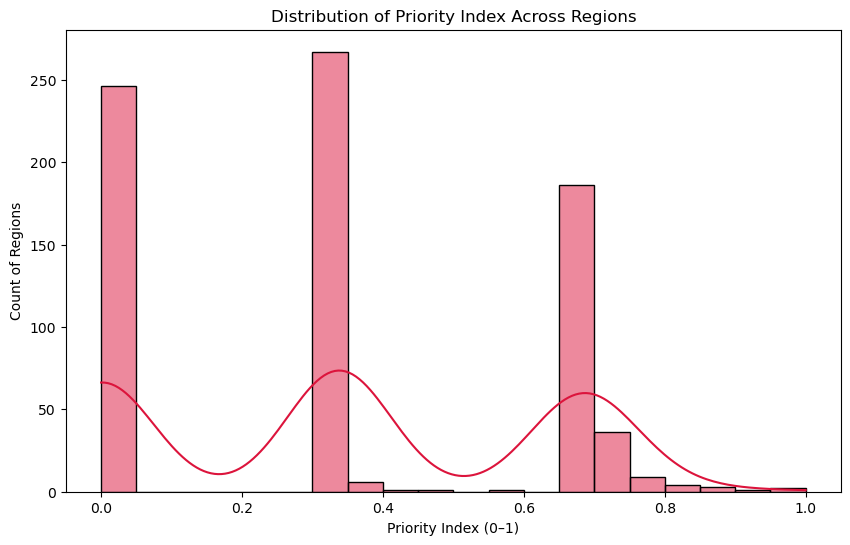

In [65]:
#Priority Distribution
plt.figure(figsize=(10,6))
sns.histplot(gdf["Priority_Index"], bins=20, kde=True, color="crimson")
plt.title("Distribution of Priority Index Across Regions")
plt.xlabel("Priority Index (0–1)")
plt.ylabel("Count of Regions")
plt.show()

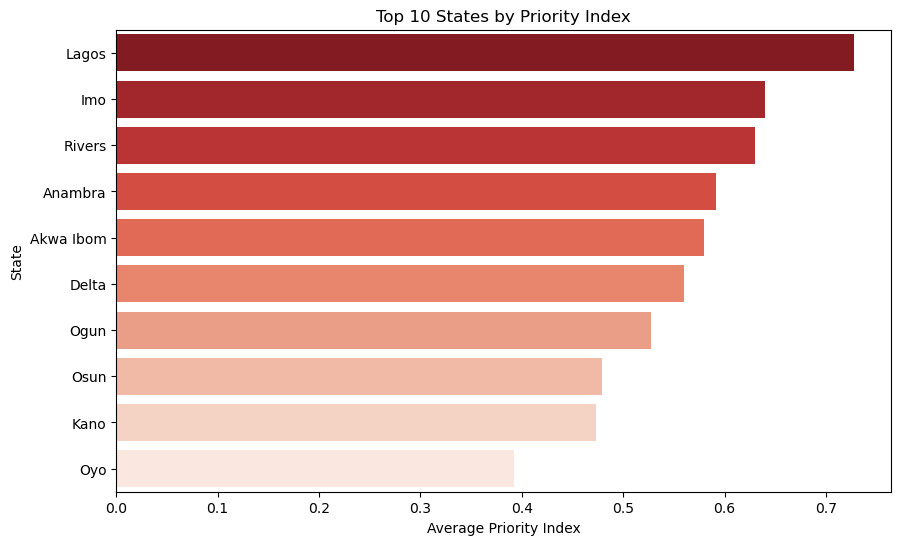

In [66]:
#Barplot of top 10 states
plt.figure(figsize=(10,6))
sns.barplot(data=state_priority.head(10), x="Priority_Index", y="GROUPED_STATE", palette="Reds_r")
plt.title("Top 10 States by Priority Index")
plt.xlabel("Average Priority Index")
plt.ylabel("State")
plt.show()

**d. Policy Recommendations**

In [67]:
#Making it rule based
def recommend_policy(row):
    """Simple rule-based recommendations per region"""
    recs = []
    if row["unsafe_ratio"] > 0.5:
        recs.append("Invest in safe water infrastructure (boreholes, treated taps)")
    if row["Solar_Tier_Label"] in ["Low"]:
        recs.append("Enhance solar deployment with higher efficiency panels")
    if row["climate_stress"] > gdf["climate_stress"].median():
        recs.append("Climate adaptation: rainwater harvesting, drought-resistant tech")
    if row["pop_density"] > gdf["pop_density"].median():
        recs.append("Prioritize urban/peri-urban service delivery")
    return "; ".join(recs) if recs else "Maintain current infrastructure, monitor conditions"

In [68]:
#Applying to a few high-priority LGAs
sample_recs = gdf.sort_values("Priority_Index", ascending=False).head(5).copy()
sample_recs["Recommendations"] = sample_recs.apply(recommend_policy, axis=1)

print("\nSample Policy Recommendations for Top LGAs:")
sample_recs[["lga", "GROUPED_STATE", "Priority_Index", "Recommendations"]]


Sample Policy Recommendations for Top LGAs:


lga GROUPED_STATE  Priority_Index  \
377              kano gwale          Kano        1.000000   
390          kano nassarawa          Kano        0.990945   
497  lagos ajeromi ifelodun         Lagos        0.926343   
628   oyo ibadan north east           Oyo        0.865767   
511            lagos mushin         Lagos        0.860756   

                                       Recommendations  
377  Climate adaptation: rainwater harvesting, drou...  
390  Climate adaptation: rainwater harvesting, drou...  
497  Climate adaptation: rainwater harvesting, drou...  
628       Prioritize urban/peri-urban service delivery  
511  Climate adaptation: rainwater harvesting, drou...

**e. Simulated Resource Allocation**

In [69]:
#Example allocation of a fixed budget across states
total_budget = 100

In [70]:
#Proportional allocation based on mean Priority_Index
state_priority["Allocation"] = (
    (state_priority["Priority_Index"] / state_priority["Priority_Index"].sum()) * total_budget
)

print("\nSimulated Budget Allocation (Top 10 States):")
state_priority.head(10)


Simulated Budget Allocation (Top 10 States):


GROUPED_STATE  Priority_Index  Allocation
0         Lagos        0.727866    9.430054
1           Imo        0.640058    8.292441
2        Rivers        0.629843    8.160099
3       Anambra        0.591143    7.658710
4     Akwa Ibom        0.579249    7.504606
5         Delta        0.560132    7.256929
6          Ogun        0.527083    6.828755
7          Osun        0.478954    6.205218
8          Kano        0.473529    6.134925
9           Oyo        0.392491    5.085020

**f. Visualizing Allocation**

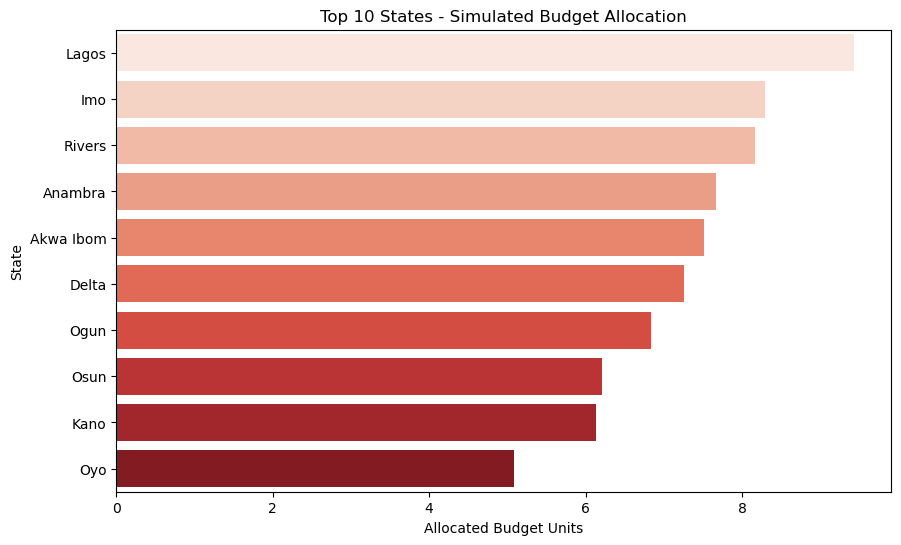

In [71]:
plt.figure(figsize=(10,6))
sns.barplot(data=state_priority.head(10), x="Allocation", y="GROUPED_STATE", palette="Reds")
plt.title("Top 10 States - Simulated Budget Allocation")
plt.xlabel("Allocated Budget Units")
plt.ylabel("State")
plt.show()

**g. Extending Recommendations with Allocation**

Attaching allocation + recommendations to gdf

In [72]:
#Applying recommendations to the full dataset (not only sample)
gdf["Recommendations"] = gdf.apply(recommend_policy, axis=1)
state_priority["Recommendations"] = gdf["Recommendations"]

In [73]:
#Creating a dictionary for both Allocation and Recommendations
allocation_map = state_priority.set_index("GROUPED_STATE")["Allocation"].to_dict()
reco_map = state_priority.set_index("GROUPED_STATE")["Recommendations"].to_dict()

In [74]:
#Mapping both into gdf
gdf["State_Allocation"] = gdf["GROUPED_STATE"].map(allocation_map)
gdf["Recommendations"] = gdf["GROUPED_STATE"].map(reco_map)

In [75]:
#Sample table - top 5 LGAs with allocation info
sample_allocation = gdf.sort_values("Priority_Index", ascending=False).head(5)
print("\nSample LGAs with Priority Index, Allocated Resources, and Recommendations:")
sample_allocation[["lga", "GROUPED_STATE", "Priority_Index", "State_Allocation", "Recommendations"]]


Sample LGAs with Priority Index, Allocated Resources, and Recommendations:


lga GROUPED_STATE  Priority_Index  State_Allocation  \
377              kano gwale          Kano        1.000000          6.134925   
390          kano nassarawa          Kano        0.990945          6.134925   
497  lagos ajeromi ifelodun         Lagos        0.926343          9.430054   
628   oyo ibadan north east           Oyo        0.865767          5.085020   
511            lagos mushin         Lagos        0.860756          9.430054   

                                       Recommendations  
377  Climate adaptation: rainwater harvesting, drou...  
390  Climate adaptation: rainwater harvesting, drou...  
497  Climate adaptation: rainwater harvesting, drou...  
628       Prioritize urban/peri-urban service delivery  
511  Climate adaptation: rainwater harvesting, drou...

### **5. Model Saving**

In [76]:
#Creating a folder to store models
os.makedirs("models", exist_ok=True)

#Random Forest Classifier
joblib.dump(clf, "models/solar_rf_model.pkl")

#KMeans model (final with best k)
joblib.dump(kmeans_final, "models/kmeans_model.pkl")

#Scaler for numeric features
joblib.dump(scaler, "models/scaler.pkl")

#Frequency encoder for LGAs
joblib.dump(lga_freq, "models/lga_freq_encoder.pkl")

#State dummy columns
joblib.dump(dummies,'models/dummy_encoder.joblib')

#PCA
joblib.dump(pca, "models/pca_2d.pkl")

#Mappings for allocations/recommendations
joblib.dump(allocation_map, "models/allocation_map.pkl")
joblib.dump(reco_map, "models/reco_map.pkl")

#GeoDataFrame to CSV file
gdf.to_csv('Cleaned Data.csv', index=False)

metadata = {
    "feature_cols": feature_cols,
    "ohe_col": ohe_col,
    "freq_col": freq_col,
    "final_columns": X.columns.tolist()
}
joblib.dump(metadata, "models/preprocessing_metadata.pkl")

print("All models, encoders, and mappings saved successfully in 'models/' folder!")

All models, encoders, and mappings saved successfully in 'models/' folder!


In [77]:
#Feature cols preview and description
feature_cols = [
    "pop_density", "safe_ratio", "unsafe_ratio", "water_diversity",
    "climate_stress", "compactness", "Distance_to_Center",
    "Average_Nighttime_mean", "AREA", "Population"
]
fc = pd.DataFrame(gdf[feature_cols])
fc.head(3)

pop_density  safe_ratio  unsafe_ratio  water_diversity  climate_stress  \
0  13569.511923    0.000159           0.0                2        0.000252   
1   7436.035102    0.000034           0.0                2        0.000262   
2    379.034030    0.000137           0.0                2        0.000236   

   compactness  Distance_to_Center  Average_Nighttime_mean     AREA  \
0    56.267020            3.180687                3.422659   18.116   
1    17.432106            3.212486                1.949728   51.131   
2    46.238316            2.743393                0.089510  386.125   

    Population  
0  245825.2780  
1  380211.9108  
2  146354.5149

In [78]:
fc.describe()

pop_density  safe_ratio  unsafe_ratio  water_diversity  \
count    763.000000  763.000000    763.000000       763.000000   
mean    1071.298961    0.000715      0.000339         3.385321   
std     3026.385225    0.001419      0.000954         1.128674   
min        4.368622    0.000000      0.000000         0.000000   
25%      111.443221    0.000204      0.000013         3.000000   
50%      253.111177    0.000417      0.000077         3.000000   
75%      603.498207    0.000849      0.000351         4.000000   
max    34682.189336    0.033815      0.016959         7.000000   

       climate_stress  compactness  Distance_to_Center  \
count      763.000000   763.000000          763.000000   
mean         0.002742    26.514605            1.293599   
std          0.023351     9.561831            1.325986   
min         -0.000806    14.054364            0.010489   
25%          0.000040    20.339876            0.347095   
50%          0.000174    23.986768            0.687745   
75%          0.000487    29.992341            2.035113   
max          0.469285    87.930597            6.224523   

       Average_Nighttime_mean          AREA    Population  
count              763.000000    763.000000  7.630000e+02  
mean                 0.750346   1152.827417  2.334111e+05  
std                  2.484964   1402.653411  2.071405e+05  
min                 -0.031743     11.645000  3.459978e+03  
25%                  0.007970    284.054500  1.147995e+05  
50%                  0.045567    680.620000  1.902565e+05  
75%                  0.231706   1485.424500  2.862055e+05  
max                 28.572277  10357.668000  2.181858e+06

In [79]:
X.columns

Index(['pop_density', 'safe_ratio', 'unsafe_ratio', 'water_diversity',
       'climate_stress', 'compactness', 'Distance_to_Center',
       'Average_Nighttime_mean', 'AREA', 'Population', 'lga_encoded',
       'state_Akwa Ibom', 'state_Anambra', 'state_Benue', 'state_Borno',
       'state_Delta', 'state_Imo', 'state_Jigawa', 'state_Kaduna',
       'state_Kano', 'state_Katsina', 'state_Kebbi', 'state_Kogi',
       'state_Lagos', 'state_Niger', 'state_Ogun', 'state_Osun',
       'state_Others', 'state_Oyo', 'state_Rivers', 'state_Sokoto'],
      dtype='object')